In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/AMS2022')


#install library ekphrasis

In [3]:
!pip install ekphrasis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    # terms that will be annotated
    #annotate={"hashtag", "allcaps", "elongated", "repeated",'emphasis', 'censored'},
    annotate={"hashtag","allcaps","elongated","repeated",'emphasis','censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


#Load Library

In [5]:
import re
import string 
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#Load dataset mentah

In [6]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AMS2022/Knalpot.csv', sep=',')  

#cek info

In [7]:
df.head()

,Tweets,cleanedTweets,Translated,Subjectivity,Polarity,Analysis
0,@Almaylifi tercium bau asap knalpot motor racing,tercium bau asap knalpot motor racing,smells of smoke exhaust motor racing,0.00,0.000000,0
1,"@hanajihyo iyaa, besok yang pake knalpot racin...","iyaa, besok yang pake knalpot racing itu aku","Yes, tomorrow I use the racing exhaust",0.00,0.000000,0
2,"Motor bebek pake knalpot racing 75ribu, lewat ...","motor bebek pake knalpot racing 75ribu, lewat ...",Duck motorbike using a 75 thousand racing exha...,0.40,-0.250000,-1
3,@SeputarTetangga Ngebutnya sih gak kenceng tap...,ngebutnya sih gak kenceng tapi kalau suara kn...,"Speed up, it's not fast, but if the sound of a...",0.60,0.133333,1
4,@18fesss Knalpot racing original,knalpot racing original,Original Racing Exhaust,0.75,0.375000,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Tweets         100 non-null    object 
 1   cleanedTweets  100 non-null    object 
 2   Translated     100 non-null    object 
 3   Subjectivity   100 non-null    float64
 4   Polarity       100 non-null    float64
 5   Analysis       100 non-null    int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 4.8+ KB


###Sisakan column Tweets dan Analysis (label)

In [9]:
del df['cleanedTweets']
del df['Translated']
del df['Subjectivity']
del df['Polarity']

In [10]:
df.head()

,Tweets,Analysis
0,@Almaylifi tercium bau asap knalpot motor racing,0
1,"@hanajihyo iyaa, besok yang pake knalpot racin...",0
2,"Motor bebek pake knalpot racing 75ribu, lewat ...",-1
3,@SeputarTetangga Ngebutnya sih gak kenceng tap...,1
4,@18fesss Knalpot racing original,1


#Preprocessing

##setting fungsi

In [11]:
def bersih_data(text):
    return " ".join(text_processor.pre_process_doc(text))

def non_ascii(text):
    return text.encode('ascii', 'replace').decode('ascii')

def remove_space_alzami(text):
    return " ".join(text.split())

def remove_emoji_alzami(text):
    return ' '.join(re.sub("([x#][A-Za-z0-9]+)"," ", text).split())

def remove_tab(text):
    return text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")

def remove_tab2(text):
    return re.sub('\s+',' ',text)

def remove_rt(text):
    return text.replace('RT'," ").replace('RT :[\s]+'," ")

def remove_mention(text):
    return ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())

def remove_incomplete_url(text):
    text = re.sub('https?:\/\/\S+', '', text)
    text = re.sub('http?:\/\/\S+', '', text)
    return text

def remove_single_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

def change_stripe(text):
    return text.replace('-'," ")

def lower(text):
    return text.lower()

def remove_punctuation(text):
    remove = string.punctuation
    remove = remove.replace("_", "") # don't remove hyphens
    pattern = r"[{}]".format(remove) # create the pattern
    return re.sub(pattern, "", text) 

##running preprocessing

In [12]:
final_string = []
for text in df['Tweets'].values:
    EachReviewText = ""
    proc = bersih_data(text)
    proc = remove_rt(proc) 
    proc = lower(proc)
    proc = change_stripe(proc)
    proc = remove_tab(proc)
    proc = remove_tab2(proc)
    proc = non_ascii(proc)
    proc = remove_incomplete_url(proc)
    proc = remove_single_char(proc)
    proc = remove_punctuation(proc)
    proc = remove_space_alzami(proc)
    EachReviewText = proc
    final_string.append(EachReviewText)

In [13]:
df["step01"] = final_string

In [14]:
df.head()

,Tweets,Analysis,step01
0,@Almaylifi tercium bau asap knalpot motor racing,0,user tercium bau asap knalpot motor racing
1,"@hanajihyo iyaa, besok yang pake knalpot racin...",0,user iyaa besok yang pake knalpot racing itu aku
2,"Motor bebek pake knalpot racing 75ribu, lewat ...",-1,motor bebek pake knalpot racing 7 5 ribu lewat...
3,@SeputarTetangga Ngebutnya sih gak kenceng tap...,1,user ngebutnya sih gak kenceng tapi kalau suar...
4,@18fesss Knalpot racing original,1,user knalpot racing original


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tweets    100 non-null    object
 1   Analysis  100 non-null    int64 
 2   step01    100 non-null    object
dtypes: int64(1), object(2)
memory usage: 2.5+ KB


##hapus record yang kosong

In [16]:
df_hapus = df[~df['step01'].str.contains(" ")]

In [17]:
df_new = df[~df.isin(df_hapus)].dropna()

In [18]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tweets    100 non-null    object
 1   Analysis  100 non-null    int64 
 2   step01    100 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.1+ KB


##normalisasi kata slang

In [19]:
# token
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
def word_tokenize_wrapper(text):
  return word_tokenize(text)

In [21]:
df_new['tokens'] = df['step01'].apply(word_tokenize_wrapper)

In [22]:
df_new.head(100)

,Tweets,Analysis,step01,tokens
0,@Almaylifi tercium bau asap knalpot motor racing,0,user tercium bau asap knalpot motor racing,"[user, tercium, bau, asap, knalpot, motor, rac..."
1,"@hanajihyo iyaa, besok yang pake knalpot racin...",0,user iyaa besok yang pake knalpot racing itu aku,"[user, iyaa, besok, yang, pake, knalpot, racin..."
2,"Motor bebek pake knalpot racing 75ribu, lewat ...",-1,motor bebek pake knalpot racing 7 5 ribu lewat...,"[motor, bebek, pake, knalpot, racing, 7, 5, ri..."
3,@SeputarTetangga Ngebutnya sih gak kenceng tap...,1,user ngebutnya sih gak kenceng tapi kalau suar...,"[user, ngebutnya, sih, gak, kenceng, tapi, kal..."
4,@18fesss Knalpot racing original,1,user knalpot racing original,"[user, knalpot, racing, original]"
...,...,...,...,...
95,@jek___ tat lu pernah ga pas kentut suaranya k...,1,user tat lu pernah ga pas kentut suaranya kek ...,"[user, tat, lu, pernah, ga, pas, kentut, suara..."
96,Saya menjual knalpot cb150 r face... seharga R...,0,saya menjual knalpot cb150 face repeated sehar...,"[saya, menjual, knalpot, cb150, face, repeated..."
97,Saya menjual knalpot fiz r stainl... seharga R...,0,saya menjual knalpot fiz stainl repeated sehar...,"[saya, menjual, knalpot, fiz, stainl, repeated..."
98,"@guddayla @cursedkidd gmw,, wili pke knalpot r...",0,user user gmw wili pke knalpot racing,"[user, user, gmw, wili, pke, knalpot, racing]"


In [24]:
normalized_word = pd.read_excel("/content/drive/My Drive/Colab Notebooks/AMS2022/kamus perbaikan kata.xlsx")

normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

df_new['tokens_perbaikan'] = df_new['tokens'].apply(normalized_term)

In [25]:
df_new.head()

,Tweets,Analysis,step01,tokens,tokens_perbaikan
0,@Almaylifi tercium bau asap knalpot motor racing,0,user tercium bau asap knalpot motor racing,"[user, tercium, bau, asap, knalpot, motor, rac...","[user, tercium, bau, asap, knalpot, motor, rac..."
1,"@hanajihyo iyaa, besok yang pake knalpot racin...",0,user iyaa besok yang pake knalpot racing itu aku,"[user, iyaa, besok, yang, pake, knalpot, racin...","[user, iyaa, besok, yang, pakai, knalpot, raci..."
2,"Motor bebek pake knalpot racing 75ribu, lewat ...",-1,motor bebek pake knalpot racing 7 5 ribu lewat...,"[motor, bebek, pake, knalpot, racing, 7, 5, ri...","[motor, bebek, pakai, knalpot, racing, 7, 5, r..."
3,@SeputarTetangga Ngebutnya sih gak kenceng tap...,1,user ngebutnya sih gak kenceng tapi kalau suar...,"[user, ngebutnya, sih, gak, kenceng, tapi, kal...","[user, ngebutnya, sih, tidak, kenceng, tapi, k..."
4,@18fesss Knalpot racing original,1,user knalpot racing original,"[user, knalpot, racing, original]","[user, knalpot, racing, original]"


In [26]:
df_new.iloc[0].tokens

['user', 'tercium', 'bau', 'asap', 'knalpot', 'motor', 'racing']

In [27]:
df_new.iloc[0].tokens_perbaikan

['user', 'tercium', 'bau', 'asap', 'knalpot', 'motor', 'racing']

##Stopword - Menggunakan Modul NLTK

In [28]:
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
stopword = nltk.corpus.stopwords.words('indonesian')

def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

df_new['Stop_removal'] = df_new['tokens_perbaikan'].apply(lambda x: remove_stopwords(x))
df_new

,Tweets,Analysis,step01,tokens,tokens_perbaikan,Stop_removal
0,@Almaylifi tercium bau asap knalpot motor racing,0,user tercium bau asap knalpot motor racing,"[user, tercium, bau, asap, knalpot, motor, rac...","[user, tercium, bau, asap, knalpot, motor, rac...","[user, tercium, bau, asap, knalpot, motor, rac..."
1,"@hanajihyo iyaa, besok yang pake knalpot racin...",0,user iyaa besok yang pake knalpot racing itu aku,"[user, iyaa, besok, yang, pake, knalpot, racin...","[user, iyaa, besok, yang, pakai, knalpot, raci...","[user, iyaa, besok, pakai, knalpot, racing]"
2,"Motor bebek pake knalpot racing 75ribu, lewat ...",-1,motor bebek pake knalpot racing 7 5 ribu lewat...,"[motor, bebek, pake, knalpot, racing, 7, 5, ri...","[motor, bebek, pakai, knalpot, racing, 7, 5, r...","[motor, bebek, pakai, knalpot, racing, 7, 5, r..."
3,@SeputarTetangga Ngebutnya sih gak kenceng tap...,1,user ngebutnya sih gak kenceng tapi kalau suar...,"[user, ngebutnya, sih, gak, kenceng, tapi, kal...","[user, ngebutnya, sih, tidak, kenceng, tapi, k...","[user, ngebutnya, sih, kenceng, suara, knalpot..."
4,@18fesss Knalpot racing original,1,user knalpot racing original,"[user, knalpot, racing, original]","[user, knalpot, racing, original]","[user, knalpot, racing, original]"
...,...,...,...,...,...,...
95,@jek___ tat lu pernah ga pas kentut suaranya k...,1,user tat lu pernah ga pas kentut suaranya kek ...,"[user, tat, lu, pernah, ga, pas, kentut, suara...","[user, tat, kamu, pernah, tidak, cocok, kentut...","[user, tat, cocok, kentut, suaranya, kayak, kn..."
96,Saya menjual knalpot cb150 r face... seharga R...,0,saya menjual knalpot cb150 face repeated sehar...,"[saya, menjual, knalpot, cb150, face, repeated...","[saya, menjual, knalpot, cb150, face, repeated...","[menjual, knalpot, cb150, face, repeated, seha..."
97,Saya menjual knalpot fiz r stainl... seharga R...,0,saya menjual knalpot fiz stainl repeated sehar...,"[saya, menjual, knalpot, fiz, stainl, repeated...","[saya, menjual, knalpot, fiz, stainl, repeated...","[menjual, knalpot, fiz, stainl, repeated, seha..."
98,"@guddayla @cursedkidd gmw,, wili pke knalpot r...",0,user user gmw wili pke knalpot racing,"[user, user, gmw, wili, pke, knalpot, racing]","[user, user, gmw, wili, pakai, knalpot, racing]","[user, user, gmw, wili, pakai, knalpot, racing]"


In [30]:
df_new.iloc[0].tokens_perbaikan

['user', 'tercium', 'bau', 'asap', 'knalpot', 'motor', 'racing']

In [31]:
df_new.iloc[0].Stop_removal

['user', 'tercium', 'bau', 'asap', 'knalpot', 'motor', 'racing']

In [32]:
i=0
final_string_tokens = []
for text in df_new['Stop_removal'].values:
    EachReviewText = ""
    EachReviewText = ' '.join(text)
    final_string_tokens.append(EachReviewText)

In [33]:
df_new["step02"] = final_string_tokens

In [34]:
df_new.head()

,Tweets,Analysis,step01,tokens,tokens_perbaikan,Stop_removal,step02
0,@Almaylifi tercium bau asap knalpot motor racing,0,user tercium bau asap knalpot motor racing,"[user, tercium, bau, asap, knalpot, motor, rac...","[user, tercium, bau, asap, knalpot, motor, rac...","[user, tercium, bau, asap, knalpot, motor, rac...",user tercium bau asap knalpot motor racing
1,"@hanajihyo iyaa, besok yang pake knalpot racin...",0,user iyaa besok yang pake knalpot racing itu aku,"[user, iyaa, besok, yang, pake, knalpot, racin...","[user, iyaa, besok, yang, pakai, knalpot, raci...","[user, iyaa, besok, pakai, knalpot, racing]",user iyaa besok pakai knalpot racing
2,"Motor bebek pake knalpot racing 75ribu, lewat ...",-1,motor bebek pake knalpot racing 7 5 ribu lewat...,"[motor, bebek, pake, knalpot, racing, 7, 5, ri...","[motor, bebek, pakai, knalpot, racing, 7, 5, r...","[motor, bebek, pakai, knalpot, racing, 7, 5, r...",motor bebek pakai knalpot racing 7 5 ribu gang...
3,@SeputarTetangga Ngebutnya sih gak kenceng tap...,1,user ngebutnya sih gak kenceng tapi kalau suar...,"[user, ngebutnya, sih, gak, kenceng, tapi, kal...","[user, ngebutnya, sih, tidak, kenceng, tapi, k...","[user, ngebutnya, sih, kenceng, suara, knalpot...",user ngebutnya sih kenceng suara knalpot mobil...
4,@18fesss Knalpot racing original,1,user knalpot racing original,"[user, knalpot, racing, original]","[user, knalpot, racing, original]","[user, knalpot, racing, original]",user knalpot racing original


##Stemming - Menggunakan Sastrawi

In [35]:
!pip install sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 6.9 MB/s 


In [36]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [37]:
final_string = []
s = ""
for sentence in df_new["step02"].values:
    filteredSentence = []
    EachReviewText = ""
    s = (stemmer.stem(sentence))
    filteredSentence.append(s)
    
    EachReviewText = ' '.join(filteredSentence)
    final_string.append(EachReviewText)

In [38]:
df_new["ProcessedText"] = final_string

In [39]:
df_new.head(5)

,Tweets,Analysis,step01,tokens,tokens_perbaikan,Stop_removal,step02,ProcessedText
0,@Almaylifi tercium bau asap knalpot motor racing,0,user tercium bau asap knalpot motor racing,"[user, tercium, bau, asap, knalpot, motor, rac...","[user, tercium, bau, asap, knalpot, motor, rac...","[user, tercium, bau, asap, knalpot, motor, rac...",user tercium bau asap knalpot motor racing,user cium bau asap knalpot motor racing
1,"@hanajihyo iyaa, besok yang pake knalpot racin...",0,user iyaa besok yang pake knalpot racing itu aku,"[user, iyaa, besok, yang, pake, knalpot, racin...","[user, iyaa, besok, yang, pakai, knalpot, raci...","[user, iyaa, besok, pakai, knalpot, racing]",user iyaa besok pakai knalpot racing,user iyaa besok pakai knalpot racing
2,"Motor bebek pake knalpot racing 75ribu, lewat ...",-1,motor bebek pake knalpot racing 7 5 ribu lewat...,"[motor, bebek, pake, knalpot, racing, 7, 5, ri...","[motor, bebek, pakai, knalpot, racing, 7, 5, r...","[motor, bebek, pakai, knalpot, racing, 7, 5, r...",motor bebek pakai knalpot racing 7 5 ribu gang...,motor bebek pakai knalpot racing 7 5 ribu gang...
3,@SeputarTetangga Ngebutnya sih gak kenceng tap...,1,user ngebutnya sih gak kenceng tapi kalau suar...,"[user, ngebutnya, sih, gak, kenceng, tapi, kal...","[user, ngebutnya, sih, tidak, kenceng, tapi, k...","[user, ngebutnya, sih, kenceng, suara, knalpot...",user ngebutnya sih kenceng suara knalpot mobil...,user ngebut sih kenceng suara knalpot mobil ra...
4,@18fesss Knalpot racing original,1,user knalpot racing original,"[user, knalpot, racing, original]","[user, knalpot, racing, original]","[user, knalpot, racing, original]",user knalpot racing original,user knalpot racing original


##simpan hasil preprocessing

In [40]:
df_new.to_csv('/content/drive/My Drive/Colab Notebooks/clean_dataset_uts.csv', sep=";")

##Penataan Data
pembagian fitur dan label

In [41]:
import pandas as pd
import numpy as np

In [42]:
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/clean_dataset_uts.csv', sep=";")

In [43]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        100 non-null    int64 
 1   Tweets            100 non-null    object
 2   Analysis          100 non-null    int64 
 3   step01            100 non-null    object
 4   tokens            100 non-null    object
 5   tokens_perbaikan  100 non-null    object
 6   Stop_removal      100 non-null    object
 7   step02            100 non-null    object
 8   ProcessedText     100 non-null    object
dtypes: int64(2), object(7)
memory usage: 7.2+ KB


In [44]:
dataset_feature = dataset['ProcessedText'].astype(str)

In [45]:
dataset_feature.head(10)

0              user cium bau asap knalpot motor racing
1                 user iyaa besok pakai knalpot racing
2    motor bebek pakai knalpot racing 7 5 ribu gang...
3    user ngebut sih kenceng suara knalpot mobil ra...
4                         user knalpot racing original
5    allcaps njing jamet banget lo allcaps allcaps ...
6    kain pekajaman ready bosque elongated fiz galv...
7    kaya oven surabaya panas ujan tar suara ngalah...
8    ie bengkel belah loba motor sonic pakai knalpo...
9    hujan tambah lagu sedih dukung unggah hapus un...
Name: ProcessedText, dtype: object

In [46]:
dataset_label = dataset['Analysis']

In [47]:
dataset_label.head(10)

0    0
1    0
2   -1
3    1
4    1
5    1
6    0
7    1
8    0
9    1
Name: Analysis, dtype: int64

##distribusi label

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


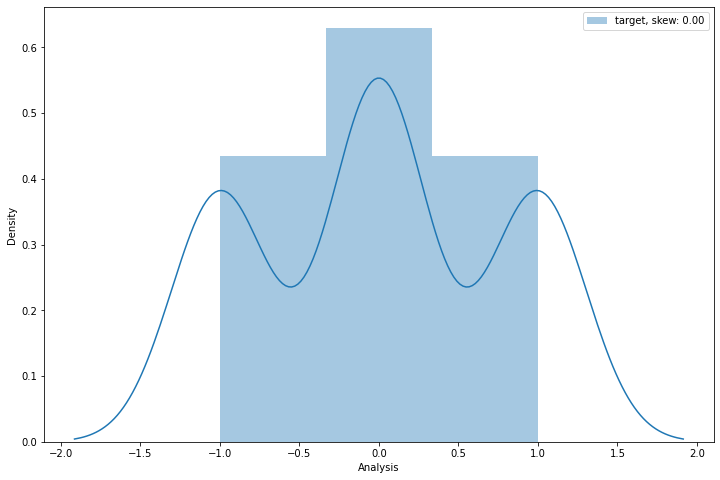

In [49]:
# Visualizing the target variable
plt.figure(figsize=(12,8))
sns.distplot(dataset_label, label=f'target, skew: {dataset_label.skew():.2f}')
plt.legend(loc='best')
plt.show()

Kesimpulan dataset : Data yang digunakan merupakan data yang seimbang karena persebaran label tidak menunjukkan adanya ketimpangan sehingga dataset ini sudah cukup mewakili dari masing masing sentimen baik positif, netral, negatif

In [50]:
dataset_label.value_counts()

 0    42
-1    29
 1    29
Name: Analysis, dtype: int64

##Ekstraksi Fitur dan Machine Learning

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

In [52]:
train_x, test_x, train_label, test_label = train_test_split(dataset_feature, dataset_label, test_size = 0.3, random_state=42)

In [53]:
test_x

83    jual knalpot racing fulls repeated harga rp955...
53    norak mas mas knalpot racing tuan nyonya mobil...
70          rt user user matic make knalpot racing aneh
45    allcaps stop knalpot racing allcaps user user ...
44          saran knalpot racing bagus merk sih bingung
39    update chatan caca number caca putus pacar kay...
22    modif velg tingkat racing number number inch p...
80    bayang pecah jalan kena muka kendara alas anji...
10                            user gara2 knalpot racing
0               user cium bau asap knalpot motor racing
18    allcaps stop knalpot racing allcaps hashtag st...
30    orang tidur ngorok na dengar ngorok kayak knal...
73    user user user user cb video knalpot pakai ori...
33    rt user keren motor pakai knalpot racing norak...
90                        user kayak knalpot racing sih
4                          user knalpot racing original
76                            kerja baik knalpot racing
77    motor bebek pakai knalpot racing 7 5 ribu 

##load TF-IDF

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_Vectorizer = TfidfVectorizer()

In [55]:
positive_reviews = df_new[(df_new["Analysis"] == 1)]
negative_reviews = df_new[(df_new["Analysis"] == -1)]
neutral_reviews = df_new[(df_new["Analysis"] == 0)]

##cek emosi neutral low

In [56]:
neutral_reviews.head()

,Tweets,Analysis,step01,tokens,tokens_perbaikan,Stop_removal,step02,ProcessedText
0,@Almaylifi tercium bau asap knalpot motor racing,0,user tercium bau asap knalpot motor racing,"[user, tercium, bau, asap, knalpot, motor, rac...","[user, tercium, bau, asap, knalpot, motor, rac...","[user, tercium, bau, asap, knalpot, motor, rac...",user tercium bau asap knalpot motor racing,user cium bau asap knalpot motor racing
1,"@hanajihyo iyaa, besok yang pake knalpot racin...",0,user iyaa besok yang pake knalpot racing itu aku,"[user, iyaa, besok, yang, pake, knalpot, racin...","[user, iyaa, besok, yang, pakai, knalpot, raci...","[user, iyaa, besok, pakai, knalpot, racing]",user iyaa besok pakai knalpot racing,user iyaa besok pakai knalpot racing
6,Pekain saja dengan pekajaman \n\nReady bosquee...,0,pekain saja dengan pekajaman ready bosque elon...,"[pekain, saja, dengan, pekajaman, ready, bosqu...","[pekain, saja, dengan, pekajaman, ready, bosqu...","[pekain, pekajaman, ready, bosque, elongated, ...",pekain pekajaman ready bosque elongated fiz ga...,kain pekajaman ready bosque elongated fiz galv...
8,Ie bengkel sebelah loba motor sonic pake knalp...,0,ie bengkel sebelah loba motor sonic pake knalp...,"[ie, bengkel, sebelah, loba, motor, sonic, pak...","[ie, bengkel, sebelah, loba, motor, sonic, pak...","[ie, bengkel, sebelah, loba, motor, sonic, pak...",ie bengkel sebelah loba motor sonic pakai knal...,ie bengkel belah loba motor sonic pakai knalpo...
10,@Husen_Jafar Gara2 knalpot racing,0,user gara2 knalpot racing,"[user, gara2, knalpot, racing]","[user, gara2, knalpot, racing]","[user, gara2, knalpot, racing]",user gara2 knalpot racing,user gara2 knalpot racing


In [57]:
Neutral_1_tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
Neutral_1_tf_idf = Neutral_1_tf_idf_vect.fit_transform(neutral_reviews["ProcessedText"].values)

In [58]:
Neutral_1_tf_idf.shape

(42, 401)

In [59]:
features = Neutral_1_tf_idf_vect.get_feature_names()

idfValues = Neutral_1_tf_idf_vect.idf_

d = dict(zip(features, 9 - idfValues))

sortedDict = sorted(d.items(), key = lambda d: d[1], reverse = True)

for i in range(200):
    print(sortedDict[i])

('knalpot', 7.927679338420374)
('racing', 7.876386044032824)
('knalpot racing', 7.735307445772918)
('user', 7.571004394481641)
('pakai', 6.723706534094438)
('motor', 6.636695157104808)
('user user', 6.541384977300483)
('number', 6.436024461642657)
('pakai knalpot', 6.436024461642657)
('repeated', 6.318241425986273)
('dapat', 6.184710033361751)
('dapat shopee', 6.184710033361751)
('harga', 6.184710033361751)
('jual', 6.184710033361751)
('jual knalpot', 6.184710033361751)
('number dapat', 6.184710033361751)
('repeated harga', 6.184710033361751)
('shopee', 6.184710033361751)
('allcaps', 6.030559353534493)
('ganti', 5.848237796740538)
('user knalpot', 5.848237796740538)
('ganti knalpot', 5.625094245426329)
('orang', 5.625094245426329)
('racing allcaps', 5.625094245426329)
('allcaps stop', 5.337412172974547)
('besok', 5.337412172974547)
('elongated', 5.337412172974547)
('fiz', 5.337412172974547)
('hashtag', 5.337412172974547)
('hashtag hashtag', 5.337412172974547)
('mobil', 5.33741217297454

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [60]:
from wordcloud import WordCloud
import matplotlib.pyplot as plot

In [61]:
def PlotWordCloud(frequency):
    worcloudPlot = WordCloud(background_color="white", width=1500, height=1000)
    worcloudPlot.generate_from_frequencies(frequencies=frequency)
    plot.figure(figsize=(15,10))
    plot.imshow(worcloudPlot, interpolation="bilinear")
    plot.axis("off")
    plot.show()

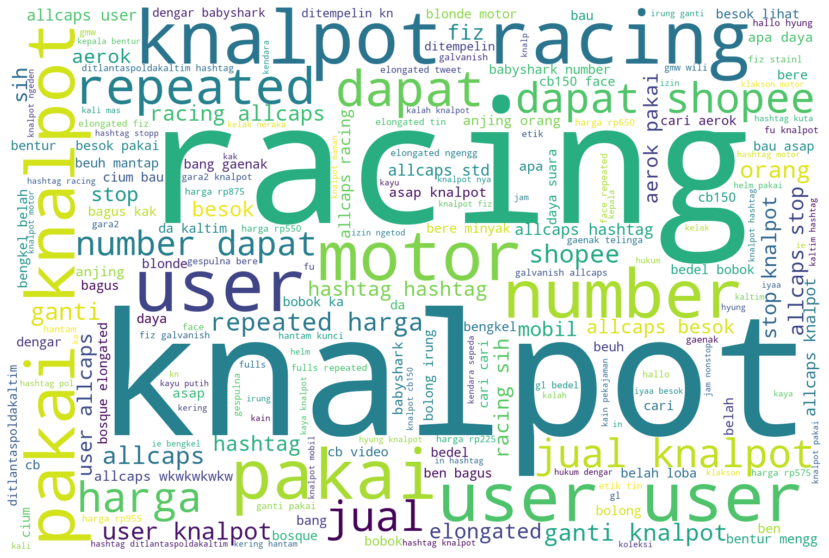

In [62]:
PlotWordCloud(d)

##cek emosi positive low

In [63]:
positive_reviews.head()

,Tweets,Analysis,step01,tokens,tokens_perbaikan,Stop_removal,step02,ProcessedText
3,@SeputarTetangga Ngebutnya sih gak kenceng tap...,1,user ngebutnya sih gak kenceng tapi kalau suar...,"[user, ngebutnya, sih, gak, kenceng, tapi, kal...","[user, ngebutnya, sih, tidak, kenceng, tapi, k...","[user, ngebutnya, sih, kenceng, suara, knalpot...",user ngebutnya sih kenceng suara knalpot mobil...,user ngebut sih kenceng suara knalpot mobil ra...
4,@18fesss Knalpot racing original,1,user knalpot racing original,"[user, knalpot, racing, original]","[user, knalpot, racing, original]","[user, knalpot, racing, original]",user knalpot racing original,user knalpot racing original
5,NJING JAMET BANGET LO. PASTI KALAU NAIK MOTOR ...,1,allcaps njing jamet banget lo allcaps allcaps ...,"[allcaps, njing, jamet, banget, lo, allcaps, a...","[allcaps, njing, jamet, banget, lo, allcaps, a...","[allcaps, njing, jamet, banget, lo, allcaps, a...",allcaps njing jamet banget lo allcaps allcaps ...,allcaps njing jamet banget lo allcaps allcaps ...
7,Rasanya dah kaya oven apalagi surabaya tuh pan...,1,rasanya dah kaya oven apalagi surabaya tuh pan...,"[rasanya, dah, kaya, oven, apalagi, surabaya, ...","[rasanya, sudah, kaya, oven, apalagi, surabaya...","[kaya, oven, surabaya, panas, ujan, tar, suara...",kaya oven surabaya panas ujan tar suaranya nga...,kaya oven surabaya panas ujan tar suara ngalah...
9,"Hujan plus lagu sedih, emang mendukung, sempat...",1,hujan plus lagu sedih emang mendukung sempat d...,"[hujan, plus, lagu, sedih, emang, mendukung, s...","[hujan, ditambah, lagu, sedih, memang, menduku...","[hujan, ditambah, lagu, sedih, mendukung, meng...",hujan ditambah lagu sedih mendukung mengunggah...,hujan tambah lagu sedih dukung unggah hapus un...


In [64]:
Positive_1_tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
Positive_1_tf_idf = Positive_1_tf_idf_vect.fit_transform(positive_reviews["ProcessedText"].values)

In [65]:
Positive_1_tf_idf.shape

(29, 407)

In [66]:
features = Positive_1_tf_idf_vect.get_feature_names()

idfValues = Positive_1_tf_idf_vect.idf_

d = dict(zip(features, 9 - idfValues))

sortedDict = sorted(d.items(), key = lambda d: d[1], reverse = True)

for i in range(200):
    print(sortedDict[i])

('knalpot', 7.966098448324319)
('racing', 7.856899156359327)
('knalpot racing', 7.68984507169616)
('user', 7.083709268125845)
('suara', 6.67824416001768)
('pakai', 6.5447127673931575)
('allcaps', 6.3905620875658995)
('iya', 6.2082405307719455)
('number', 6.2082405307719455)
('pakai knalpot', 6.2082405307719455)
('repeated', 6.2082405307719455)
('sih', 6.2082405307719455)
('allcaps allcaps', 5.985096979457735)
('banget', 5.985096979457735)
('kayak', 5.985096979457735)
('kayak knalpot', 5.985096979457735)
('kenceng', 5.985096979457735)
('kendara', 5.985096979457735)
('motor', 5.985096979457735)
('number knalpot', 5.985096979457735)
('rt', 5.985096979457735)
('rt user', 5.985096979457735)
('suara knalpot', 5.985096979457735)
('alas', 5.697414907005954)
('alas anjing', 5.697414907005954)
('allcaps new', 5.697414907005954)
('anjing', 5.697414907005954)
('anjing anjingin', 5.697414907005954)
('anjingin', 5.697414907005954)
('anjingin knalpot', 5.697414907005954)
('baik', 5.697414907005954)
(

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [67]:
from wordcloud import WordCloud
import matplotlib.pyplot as plot

In [68]:
def PlotWordCloud(frequency):
    worcloudPlot = WordCloud(background_color="white", width=1500, height=1000)
    worcloudPlot.generate_from_frequencies(frequencies=frequency)
    plot.figure(figsize=(15,10))
    plot.imshow(worcloudPlot, interpolation="bilinear")
    plot.axis("off")
    plot.show()

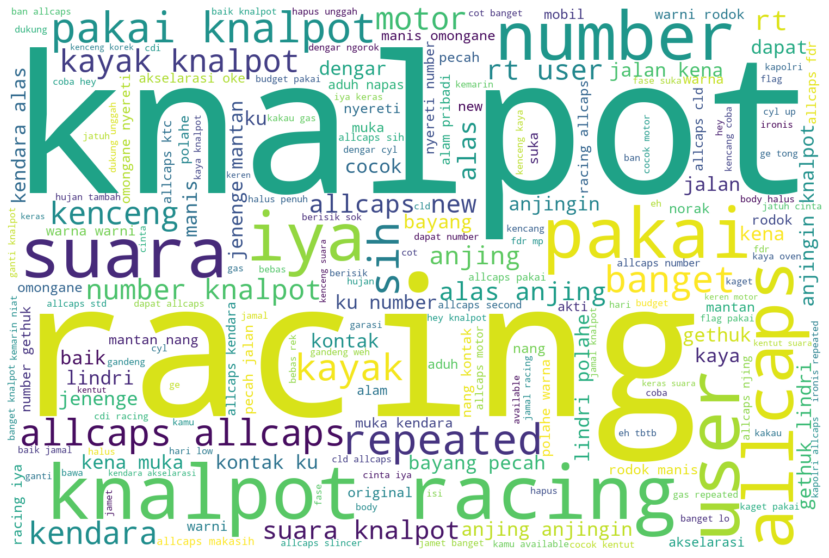

In [69]:
PlotWordCloud(d)

##cek emosi negative

In [70]:
negative_reviews = df_new[(df_new["Analysis"] == -1)]

In [71]:
Negative_1_tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
Negative_1_tf_idf = Negative_1_tf_idf_vect.fit_transform(negative_reviews["ProcessedText"].values)

In [72]:
Negative_1_tf_idf.shape

(29, 265)

In [73]:
features = Negative_1_tf_idf_vect.get_feature_names()

idfValues = Negative_1_tf_idf_vect.idf_

d = dict(zip(features, 9 - idfValues))

sortedDict = sorted(d.items(), key = lambda d: d[1], reverse = True)

for i in range(200):
    print(sortedDict[i])

('racing', 7.966098448324319)
('knalpot', 7.931007128513048)
('knalpot racing', 7.894639484342173)
('user', 7.371391340577626)
('pakai', 7.237859947953103)
('motor', 6.996697891136215)
('pakai knalpot', 6.996697891136215)
('aneh', 6.90138771133189)
('matic', 6.90138771133189)
('racing aneh', 6.90138771133189)
('make', 6.796027195674064)
('make knalpot', 6.796027195674064)
('matic make', 6.796027195674064)
('user matic', 6.796027195674064)
('user user', 6.796027195674064)
('rt', 6.67824416001768)
('rt user', 6.67824416001768)
('bebek', 6.3905620875658995)
('bebek pakai', 6.3905620875658995)
('disumpahin', 6.3905620875658995)
('gang', 6.3905620875658995)
('gang disumpahin', 6.3905620875658995)
('motor bebek', 6.3905620875658995)
('racing ribu', 6.3905620875658995)
('ribu', 6.3905620875658995)
('ribu gang', 6.3905620875658995)
('number', 5.985096979457735)
('balap', 5.697414907005954)
('banget', 5.697414907005954)
('berisik', 5.697414907005954)
('cc', 5.697414907005954)
('kau', 5.69741490

In [74]:
from wordcloud import WordCloud
import matplotlib.pyplot as plot

In [75]:
def PlotWordCloud(frequency):
    worcloudPlot = WordCloud(background_color="white", width=1500, height=1000)
    worcloudPlot.generate_from_frequencies(frequencies=frequency)
    plot.figure(figsize=(15,10))
    plot.imshow(worcloudPlot, interpolation="bilinear")
    plot.axis("off")
    plot.show()

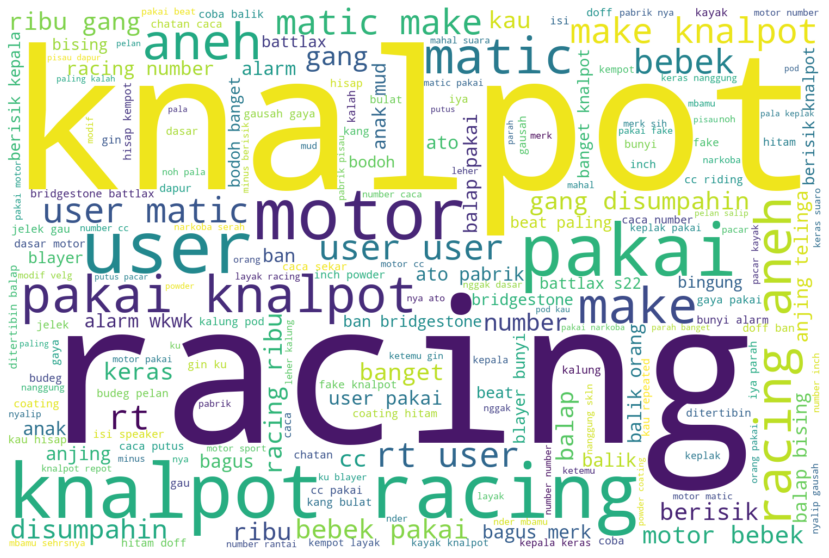

In [76]:
PlotWordCloud(d)

##Cek emosi untuk Semua label

In [77]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2))

In [78]:
Data_TFIDF = tfidf_vect.fit_transform(df_new["ProcessedText"].values)

In [79]:
Data_TFIDF.shape

(100, 992)

In [80]:
vectorizer = TfidfVectorizer(ngram_range = (1,2))

In [81]:
X = vectorizer.fit_transform(df_new["ProcessedText"].values)

In [82]:
print(X.shape)

(100, 992)


In [83]:
features = vectorizer.get_feature_names_out()

In [84]:
features

array(['aduh', 'aduh napas', 'aerok', 'aerok pakai', 'akselarasi',
       'akselarasi oke', 'akti', 'alam', 'alam pribadi', 'alarm',
       'alarm wkwk', 'alas', 'alas anjing', 'allcaps', 'allcaps allcaps',
       'allcaps besok', 'allcaps cld', 'allcaps fdr', 'allcaps hashtag',
       'allcaps kendara', 'allcaps knalpot', 'allcaps ktc',
       'allcaps makasih', 'allcaps motor', 'allcaps new', 'allcaps njing',
       'allcaps number', 'allcaps pakai', 'allcaps racing',
       'allcaps second', 'allcaps sih', 'allcaps slincer', 'allcaps std',
       'allcaps stop', 'allcaps user', 'allcaps wkwkwkwkw', 'anak',
       'anak mud', 'aneh', 'anjing', 'anjing anjingin', 'anjing orang',
       'anjing telinga', 'anjingin', 'anjingin knalpot', 'apa',
       'apa daya', 'asap', 'asap knalpot', 'ato', 'ato pabrik',
       'available', 'babyshark', 'babyshark number', 'bagus', 'bagus kak',
       'bagus merk', 'baik', 'baik jamal', 'baik knalpot', 'balap',
       'balap bising', 'balap pakai', 'b

In [85]:
idfValues = vectorizer.idf_

In [86]:
d = dict(zip(features, 9 - idfValues))

In [87]:
sortedDict = sorted(d.items(), key = lambda d: d[1], reverse = True)

In [88]:
for i in range(992):
    print(sortedDict[i])

('knalpot', 7.938756374759281)
('racing', 7.895738989675591)
('knalpot racing', 7.766906117832622)
('user', 7.373863529723015)
('pakai', 6.818866687643887)
('motor', 6.5629333135066865)
('pakai knalpot', 6.52037369908789)
('user user', 6.275251241054905)
('number', 6.157468205398522)
('repeated', 5.9498288406202775)
('allcaps', 5.782774755957111)
('make', 5.782774755957111)
('matic', 5.782774755957111)
('rt', 5.782774755957111)
('rt user', 5.782774755957111)
('aneh', 5.687464576152786)
('make knalpot', 5.687464576152786)
('racing aneh', 5.687464576152786)
('suara', 5.687464576152786)
('dapat', 5.582104060494959)
('matic make', 5.582104060494959)
('user matic', 5.582104060494959)
('sih', 5.4643210248385765)
('dapat shopee', 5.330789632214054)
('harga', 5.330789632214054)
('jual', 5.330789632214054)
('jual knalpot', 5.330789632214054)
('number dapat', 5.330789632214054)
('repeated harga', 5.330789632214054)
('shopee', 5.330789632214054)
('user knalpot', 5.330789632214054)
('banget', 5.17

In [89]:
def PlotWordCloud(frequency):
    worcloudPlot = WordCloud(background_color="white", width=1500, height=1000)
    worcloudPlot.generate_from_frequencies(frequencies=frequency)
    plot.figure(figsize=(15,10))
    plot.imshow(worcloudPlot, interpolation="bilinear")
    plot.axis("off")
    plot.show()

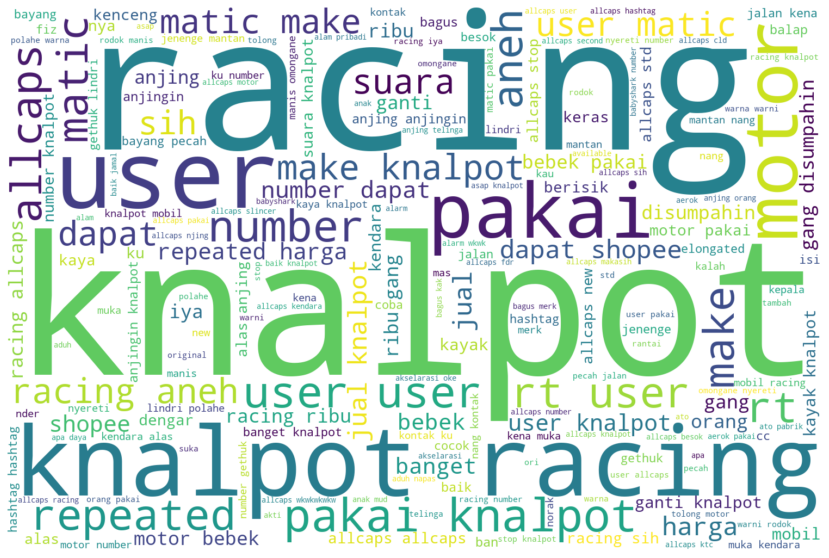

In [90]:
PlotWordCloud(d)

In [91]:
from sklearn.naive_bayes import MultinomialNB

In [92]:
from sklearn.pipeline import Pipeline
classifier_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', MultinomialNB()),
])

In [93]:
parameters_nb = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100)
}

In [94]:
classifier_nb = GridSearchCV(classifier_nb, parameters_nb, cv = 3, n_jobs=-1)

In [95]:
classifier_nb.fit(train_x, train_label.ravel())

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('model', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100),
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                (1, 4)]})

In [96]:
y_pred_nb_train = classifier_nb.predict(train_x)
accuracy_nb_train = accuracy_score(train_label, y_pred_nb_train)
print("Accuracy Training set: ", accuracy_nb_train)

y_pred_nb_test = classifier_nb.predict(test_x)
accuracy_nb_test = accuracy_score(test_label, y_pred_nb_test)
print("Accuracy Test set: ", accuracy_nb_test)

Accuracy Training set:  1.0
Accuracy Test set:  0.6333333333333333


In [97]:
recall_nb_train = recall_score(train_label, y_pred_nb_train, average='weighted')
print("Recall Training set: ", recall_nb_train)

recall_nb_test = recall_score(test_label, y_pred_nb_test, average='weighted')
print("Recall Test set: ", recall_nb_test)

Recall Training set:  1.0
Recall Test set:  0.6333333333333333


In [98]:
precision_nb_train = precision_score(train_label, y_pred_nb_train, average='weighted')
print("Precision Training set: ", precision_nb_train)

precision_nb_test = precision_score(test_label, y_pred_nb_test, average='weighted')
print("Precision Test set: ", precision_nb_test)

Precision Training set:  1.0
Precision Test set:  0.6452380952380953


In [99]:
f1_nb_train = f1_score(train_label, y_pred_nb_train, average='weighted')
print("F1 Training set: ", f1_nb_train)

f1_nb_test = f1_score(test_label, y_pred_nb_test, average='weighted')
print("F1 Test set: ", f1_nb_test)

F1 Training set:  1.0
F1 Test set:  0.6227513227513228


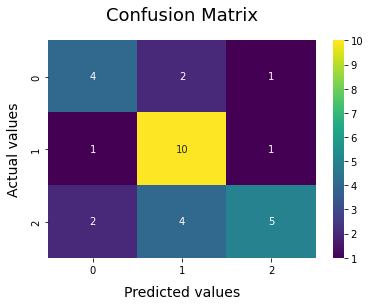

In [100]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_label, y_pred_nb_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

In [101]:
classifier_nb.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model', MultinomialNB(alpha=0.1))])

In [102]:
for param_name in sorted(parameters_nb.keys()):
    print("%s: %r" % (param_name, classifier_nb.best_params_[param_name]))

model__alpha: 0.1
tfidf__ngram_range: (1, 1)


In [103]:
models = [        
          ('Naive Bayes Multinomial', accuracy_nb_train, accuracy_nb_test),
         ]

In [104]:
predict = pd.DataFrame(data = models, columns=['Model', 'Training Accuracy', 'Test Accuracy'])
predict

,Model,Training Accuracy,Test Accuracy
0,Naive Bayes Multinomial,1.0,0.633333


In [105]:
models_comparison = [                        
                        ('Naive Bayes Multinomial', accuracy_nb_test, recall_nb_test, precision_nb_test, f1_nb_test)                      
                    ]

In [106]:
comparison = pd.DataFrame(data = models_comparison, columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Weighted'])
comparison

,Model,Accuracy,Recall,Precision,F1 Weighted
0,Naive Bayes Multinomial,0.633333,0.633333,0.645238,0.622751


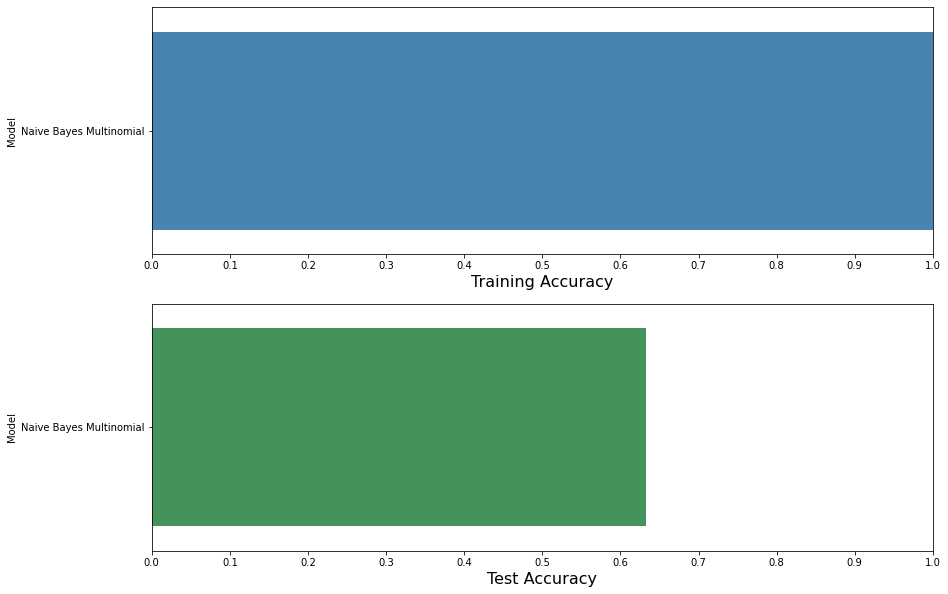

In [107]:
import numpy as np

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['Training Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Training Accuracy', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('Training Accuracy', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)
axes[0].set_xticks(np.arange(0, 1.1, 0.1))

predict.sort_values(by=['Test Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Test Accuracy', y='Model', data = predict, palette='Greens_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('Test Accuracy', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)
axes[1].set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

Kesimpulan : 
Dari klasifikasi diatas menunjukkan hasil dengan keadaan data overfitting. Hal ini terjadi karena data yang digunakan untuk pelatihan itu adalah yang "terbaik", sehingga apabila dilakukan tes dengan menggunakan data yang berbeda dapat mengurangi akurasi. 

Best Parameter : (model__alpha: 0.1), (tfidf__ngram_range: (1, 1))